In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
from PIL import Image
from pylab import rcParams
import nibabel as nib
import joblib
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, SpatialDropout2D
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras import backend as K
import joblib
import gc
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Предподготовка

In [ ]:
root_path = '/content/drive/MyDrive'
img_size = 256
raw_data = pd.read_csv(root_path + '/input/covid19-ct-scans/metadata.csv')
raw_data['ct_scan'] = raw_data['ct_scan'].str[3:]
raw_data['lung_mask'] = raw_data['lung_mask'].str[3:]
raw_data['infection_mask'] = raw_data['infection_mask'].str[3:]
raw_data['lung_and_infection_mask'] = raw_data['lung_and_infection_mask'].str[3:]
raw_data.head()

ct_scan  \
0  input/covid19-ct-scans/ct_scans/coronacases_or...   
1  input/covid19-ct-scans/ct_scans/coronacases_or...   
2  input/covid19-ct-scans/ct_scans/coronacases_or...   
3  input/covid19-ct-scans/ct_scans/coronacases_or...   
4  input/covid19-ct-scans/ct_scans/coronacases_or...   

                                           lung_mask  \
0  input/covid19-ct-scans/lung_mask/coronacases_0...   
1  input/covid19-ct-scans/lung_mask/coronacases_0...   
2  input/covid19-ct-scans/lung_mask/coronacases_0...   
3  input/covid19-ct-scans/lung_mask/coronacases_0...   
4  input/covid19-ct-scans/lung_mask/coronacases_0...   

                                      infection_mask  \
0  input/covid19-ct-scans/infection_mask/coronaca...   
1  input/covid19-ct-scans/infection_mask/coronaca...   
2  input/covid19-ct-scans/infection_mask/coronaca...   
3  input/covid19-ct-scans/infection_mask/coronaca...   
4  input/covid19-ct-scans/infection_mask/coronaca...   

                             lung_and_infection_mask  
0  input/covid19-ct-scans/lung_and_infection_mask...  
1  input/covid19-ct-scans/lung_and_infection_mask...  
2  input/covid19-ct-scans/lung_and_infection_mask...  
3  input/covid19-ct-scans/lung_and_infection_mask...  
4  input/covid19-ct-scans/lung_and_infection_mask...

In [ ]:
def clahe_enhancer(test_img, demo):

    test_img = test_img*255
    test_img = np.uint8(test_img)
    test_img_flattened = test_img.flatten()

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(test_img)
    clahe_image_flattened = clahe_image.flatten()

    if demo == 1:

        fig = plt.figure()
        rcParams['figure.figsize'] = 10,10

        plt.subplot(2, 2, 1)
        plt.imshow(test_img, cmap='bone')
        plt.title("Original CT-Scan")

        plt.subplot(2, 2, 2)
        plt.hist(test_img_flattened)
        plt.title("Histogram of Original CT-Scan")

        plt.subplot(2, 2, 3)
        plt.imshow(clahe_image, cmap='bone')
        plt.title("CLAHE Enhanced CT-Scan")

        plt.subplot(2, 2, 4)
        plt.hist(clahe_image_flattened)
        plt.title("Histogram of CLAHE Enhanced CT-Scan")

    return(clahe_image)

In [ ]:
def cropper(test_img, demo):

    test_img = test_img*255
    test_img = np.uint8(test_img)

    contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]

    x = np.argsort(areas)

    max_index = x[x.size - 1]
    cnt1=contours[max_index]
    second_max_index = x[x.size - 2]
    cnt2 = contours[second_max_index]


    x,y,w,h = cv2.boundingRect(cnt1)
    p,q,r,s = cv2.boundingRect(cnt2)

    cropped1 = test_img[y:y+h, x:x+w]
    cropped1 = cv2.resize(cropped1, dsize=(128,256), interpolation=cv2.INTER_AREA)
    cropped2 = test_img[q:q+s, p:p+r]
    cropped2 = cv2.resize(cropped2, dsize=(128,256), interpolation=cv2.INTER_AREA)

    fused = np.concatenate((cropped1, cropped2), axis=1)


    points_lung1 = []
    points_lung2 = []

    points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
    points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)


    return(fused, points_lung1, points_lung2)

In [ ]:
all_points1 = []
all_points2 = []

In [ ]:
def read_nii(filepath, data, string):
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))


    if string == "lungs":
        all_points1 = []
        all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
            continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
            img[img>0]=1
            img, points1, points2 = cropper(img, demo = 0)
            all_points1.append((points1[0], points1[1], points1[2], points1[3]))
            all_points2.append((points2[0], points2[1], points2[2], points2[3]))
            continue

        if string == "cts" and img_no < len(all_points1):
            img = clahe_enhancer(img, demo = 0)
            a,b,c,d = all_points1[img_no]
            e,f,g,h = all_points2[img_no]

            if b > f: high = d
            else: high = h

            if a > e: width = c
            else: width = g

            img = img[min(b, f):max(b, f) + high, min(a, e): max(a, e) + width]
            img = cv2.resize(img, dsize=(256,256), interpolation=cv2.INTER_AREA)

        if string == "infections" and img_no < len(all_points1):
            a,b,c,d = all_points1[img_no]
            e,f,g,h = all_points2[img_no]
            img = np.uint8(img*255)
            img1 = img[b:b+d, a:a+c]
            img1 = cv2.resize(img1, dsize=(128,256), interpolation=cv2.INTER_AREA)
            img2 = img[f:f+h, e:e+g]
            img2 = cv2.resize(img2, dsize=(128,256), interpolation=cv2.INTER_AREA)
            img = np.concatenate((img1, img2), axis=1)



        data.append(img)

In [ ]:
cts = []
lungs = []
infections = []

In [ ]:
for i in range(0, 20):
    read_nii(root_path + '/' + raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(root_path + '/' + raw_data.loc[i,'ct_scan'], cts, 'cts')
    read_nii(root_path + '/' + raw_data.loc[i,'infection_mask'], infections, 'infections')

<ipython-input-7-b9a1206684d9>:21: RuntimeWarning: invalid value encountered in divide
  img = (img - xmin)/(xmax - xmin)
<ipython-input-7-b9a1206684d9>:47: RuntimeWarning: invalid value encountered in cast
  img = np.uint8(img*255)


In [ ]:
no_masks = []
for i in range(0, len(infections)):
    if np.unique(infections[i]).size == 1:
        no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))

for index in sorted(no_masks, reverse = True):
    del infections[index]
    del cts[index]


Number of complete black masks : 498


In [ ]:
gc.collect()

26

(256, 256) (256, 256)


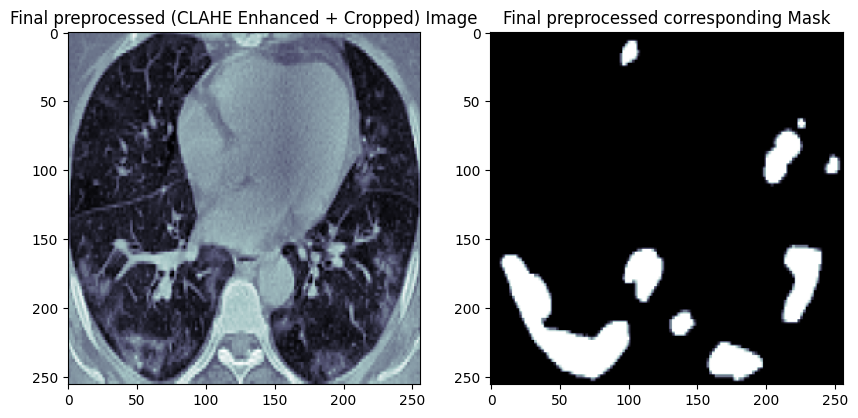

In [ ]:
x = 60
rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(infections[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, infections[x].shape)

In [ ]:
new_dim = 224

In [ ]:
for i in range(0,len(cts)):
    cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
    infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)

Аугментация

In [ ]:
cts = np.array(cts)
infections = np.array(infections)

In [ ]:
cts = np.uint8(cts)
infections = np.uint8(infections)

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30), # rotate by -30 to +30 degrees
            shear=(-15, 15), # shear by -15 to +15 degrees
        ))
], random_order=True)

In [ ]:
len(cts) * 0.25

403.5

In [ ]:
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)

In [ ]:
no_of_aug_imgs = 403
random_indices = np.random.randint(0, cts.shape[0], size=no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]

In [ ]:
cts_aug, infections_aug = seq(images=sample_cts, segmentation_maps=sample_inf)

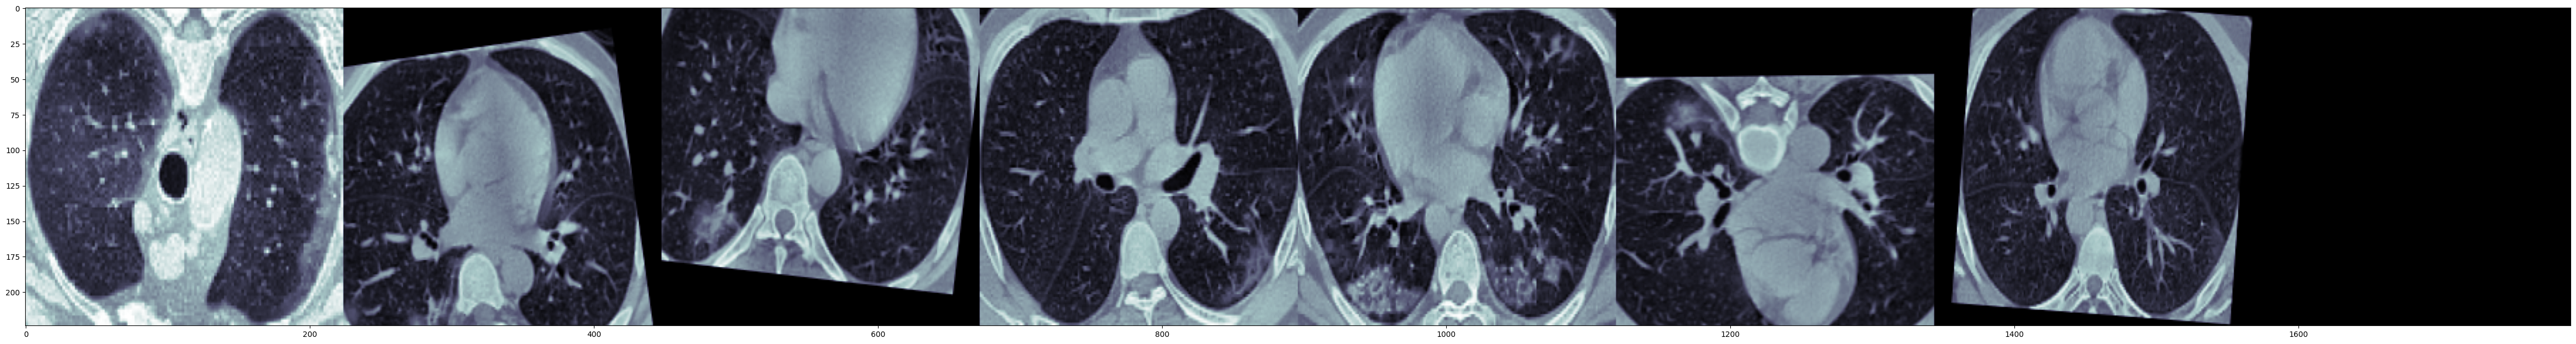

In [ ]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')
plt.grid(False)

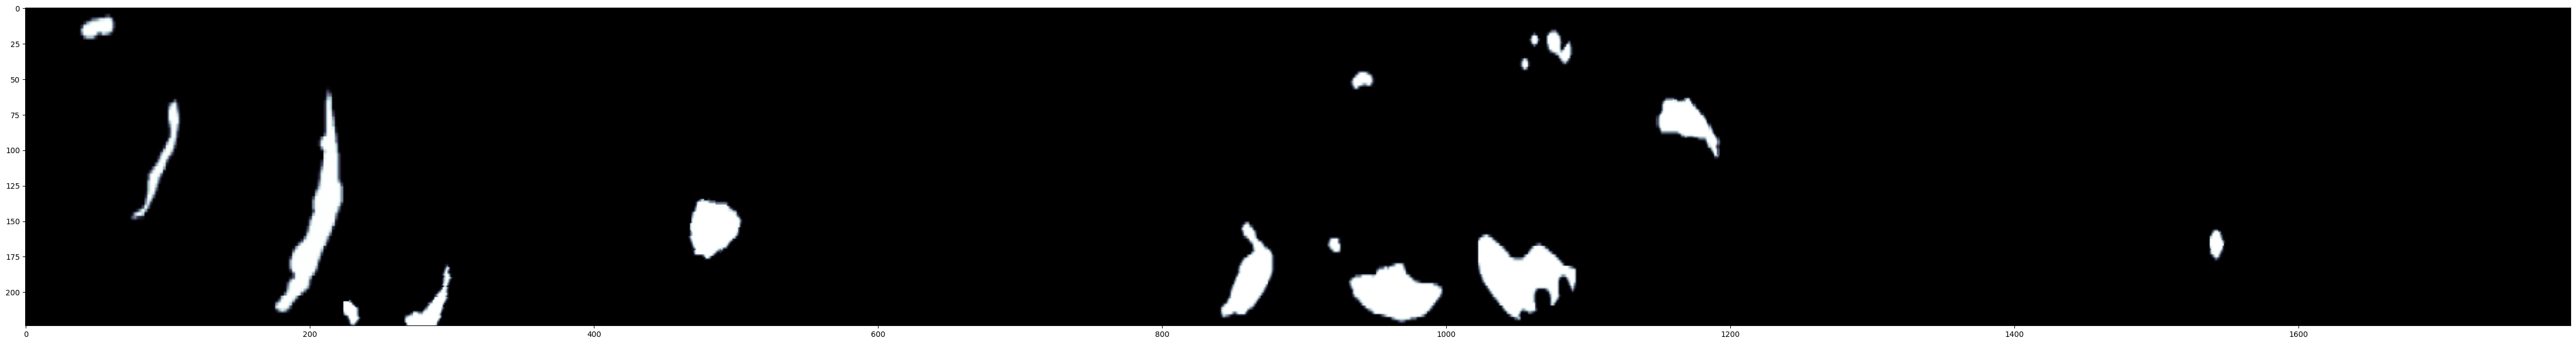

In [ ]:
rcParams['figure.figsize'] = 60,60
cells1 = infections_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')
plt.grid(False)

In [ ]:
cts_aug = cts_aug.reshape(len(cts_aug), new_dim, new_dim, 1)
infections_aug = infections_aug.reshape(len(infections_aug), new_dim, new_dim, 1)

In [ ]:
cts = np.concatenate((cts, cts_aug))
infections = np.concatenate((infections, infections_aug))

In [ ]:
cts = cts/255
infections = infections/255

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')



    plt.show()

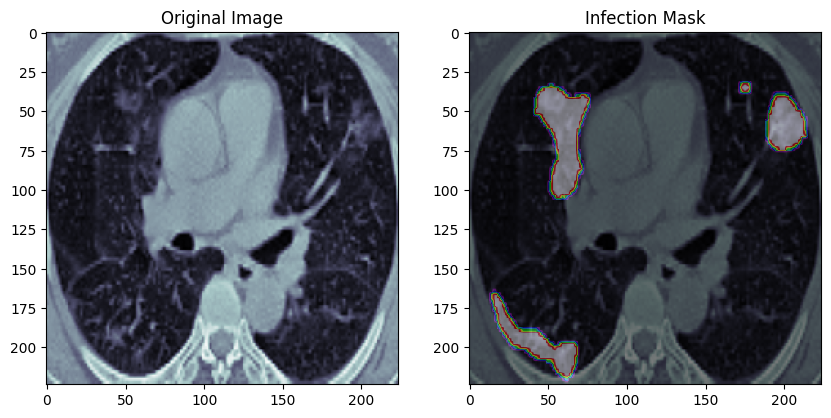

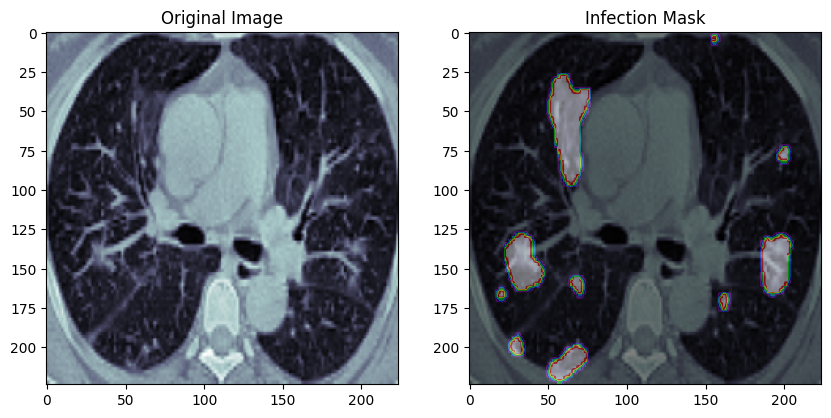

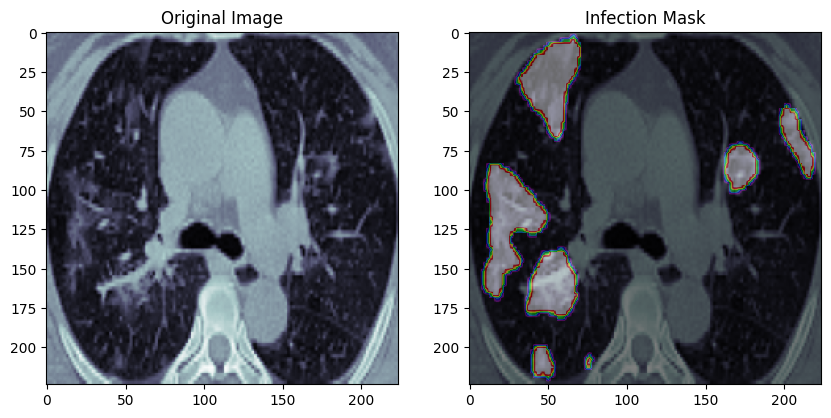

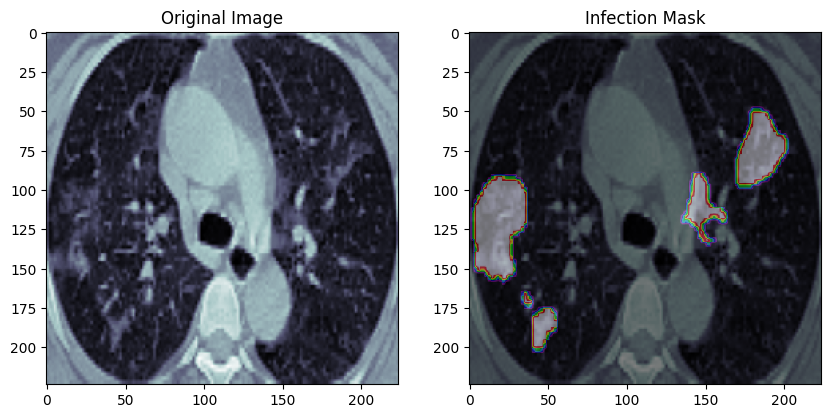

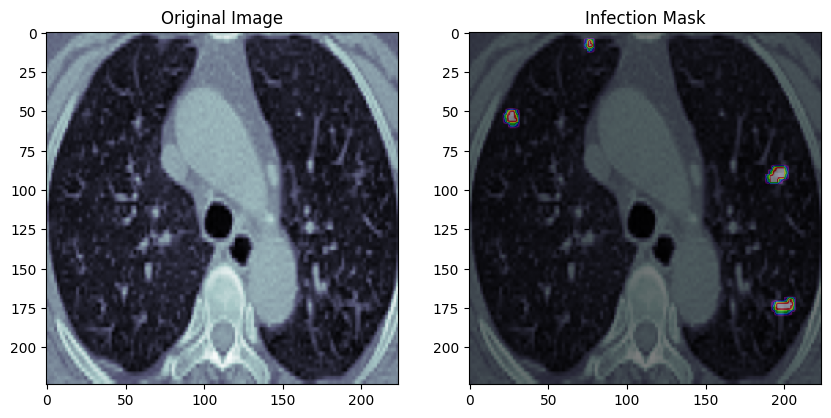

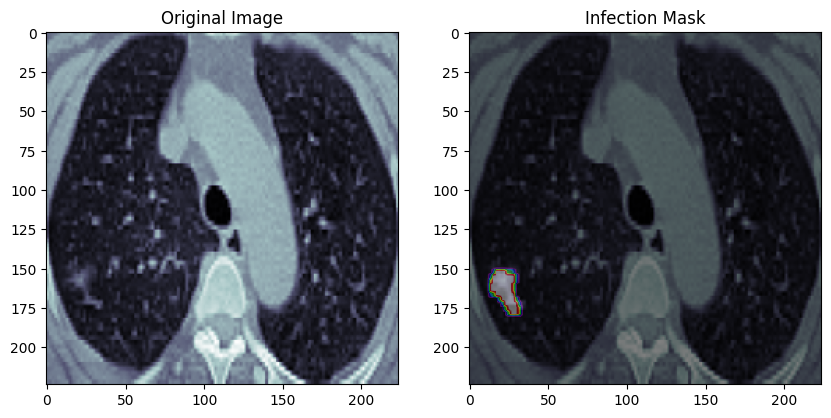

In [ ]:
for index in [100,110,120,130,140,150]:
    plot_sample([cts[index], infections[index]])

Обучение модели

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(cts, infections, test_size=0.2, random_state=42)

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_pred_f = K.cast(y_pred, 'float32')
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

In [ ]:
inputs = Input((new_dim, new_dim, 1))

c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.25)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.25)(p4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 224, 224, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 224, 224, 32)   │            128 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 32)   │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 112, 112, 32)   │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 112, 112, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 56, 56, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 56, 56, 64)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 56, 56, 128)    │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 28, 28, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 28, 28, 128)    │              0 │ max_pooling2d_6[0][0]  │
├──────────────────────

 Total params: 7,765,281 (29.62 MB)

 Trainable params: 7,762,401 (29.61 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
batch_size = 32
epochs = 50
filepath_dice_coeff="unet_covid_weights_dice_coeff.keras"
filepath_loss = "unet_covid_weights_val_loss.keras"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=bce_dice_loss, metrics=[dice_coeff])

In [ ]:
del lungs
del cts_aug
del infections_aug
gc.collect()

NameError: name 'lungs' is not defined

In [ ]:
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coeff: 0.1445 - loss: 0.6693   
Epoch 1: val_dice_coeff improved from -inf to 0.08262, saving model to unet_covid_weights_dice_coeff.keras

Epoch 1: val_loss improved from inf to 0.59991, saving model to unet_covid_weights_val_loss.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - dice_coeff: 0.1452 - loss: 0.6674 - val_dice_coeff: 0.0826 - val_loss: 0.5999
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - dice_coeff: 0.3938 - loss: 0.4013
Epoch 2: val_dice_coeff did not improve from 0.08262

Epoch 2: val_loss did not improve from 0.59991
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 467ms/step - dice_coeff: 0.3949 - loss: 0.4007 - val_dice_coeff: 0.0295 - val_loss: 0.6449
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - dice_coeff: 0.5564 - loss: 0.3084
Epoch 3: val_dice_coeff did not improve from 0.08262

Epoch 3: val_loss did not improve from 0.59991
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - dice_coeff: 0.5565 - loss: 0.3084 - val_di

In [ ]:
gc.collect()

9173

In [ ]:
model.save('/content/infection_segmentation.keras')

In [ ]:
model.load_weights(filepath_dice_coeff)

In [ ]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - dice_coeff: 0.7746 - loss: 0.1830
test loss, test dice coefficient: [0.1770029217004776, 0.7818403244018555]


In [ ]:
del x_valid
del y_valid
del x_train
del y_train
gc.collect()

774

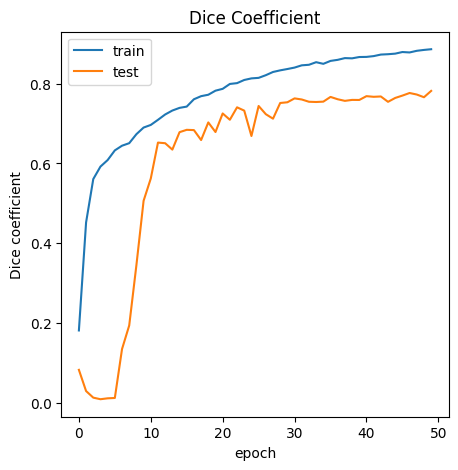

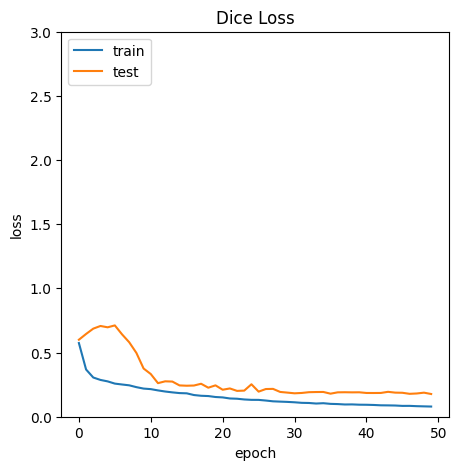

In [ ]:
rcParams['figure.figsize'] = 5, 5
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 3)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def compare_actual_and_predicted(image_no):
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(infections[image_no].reshape(new_dim,new_dim), cmap='bone')
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Predicted mask')

    plt.show()

Сравнение с реальными изображениями

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


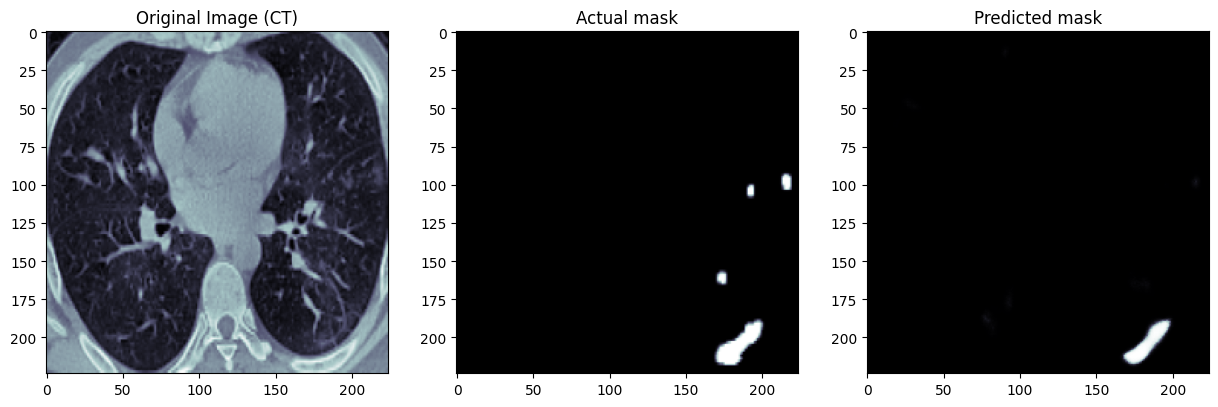

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


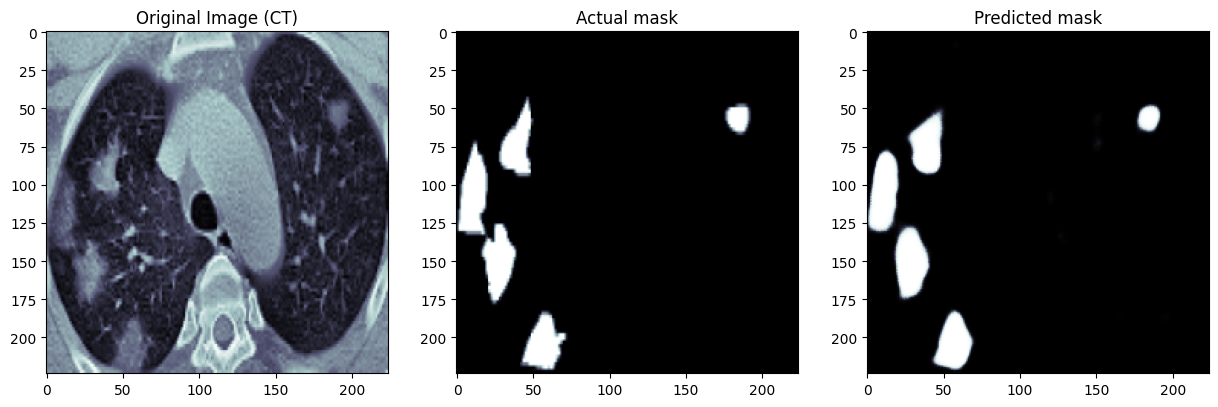

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


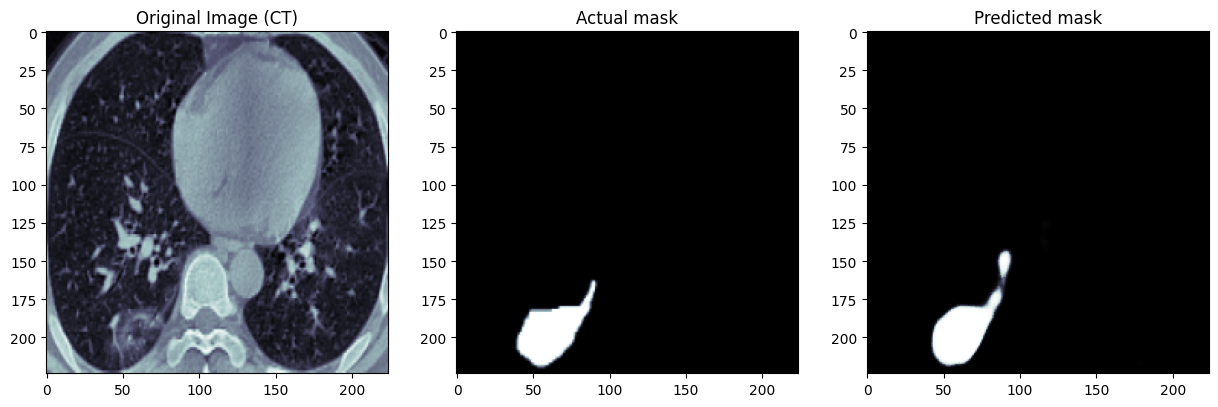

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


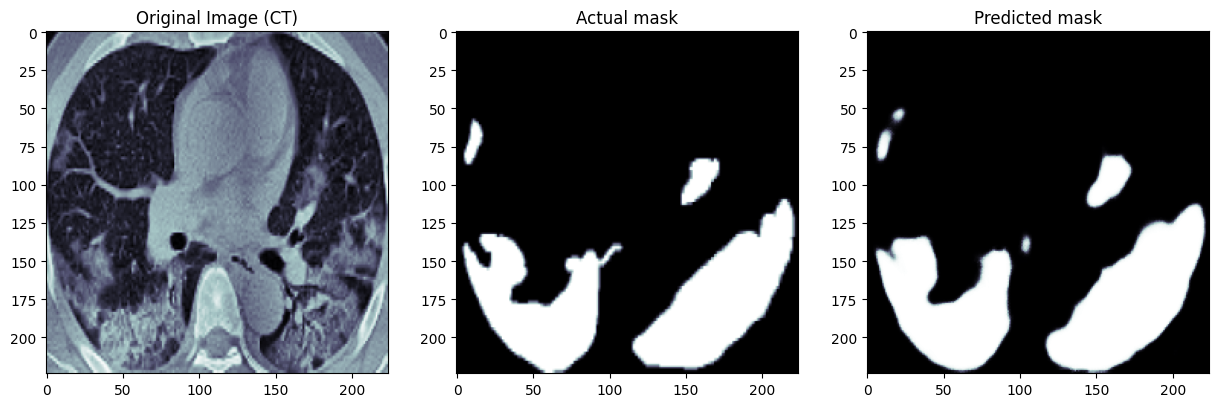

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


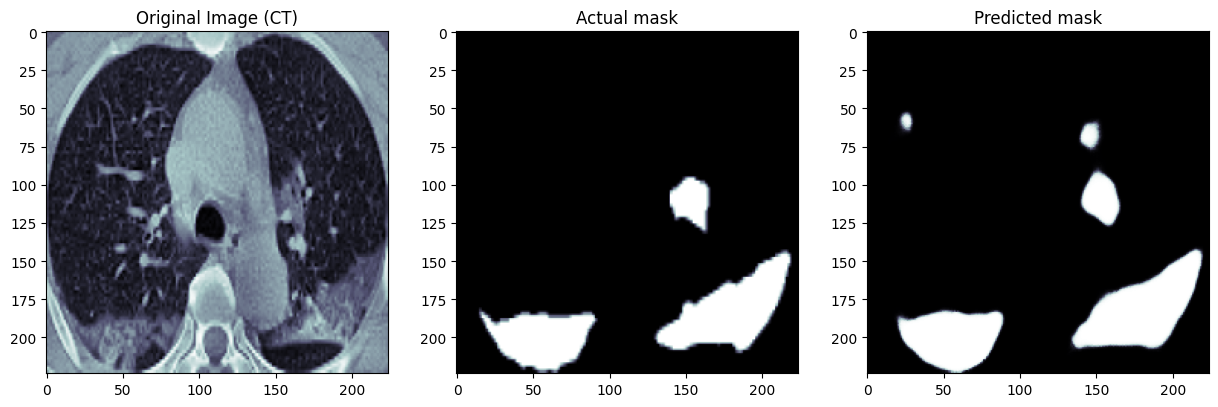

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


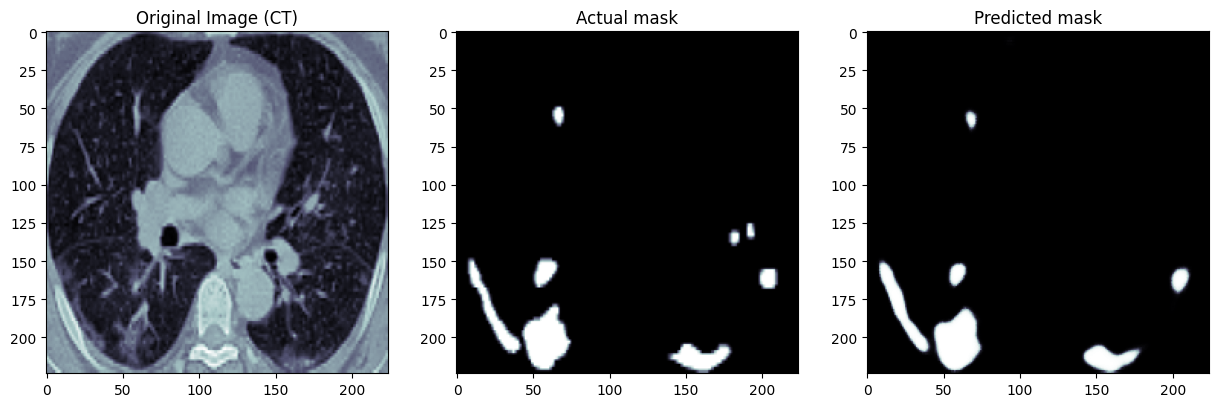

In [ ]:
for i in [440,269,555, 355, 380, 90]:
    compare_actual_and_predicted(i)

Сравнение с аугментированными изображениями

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


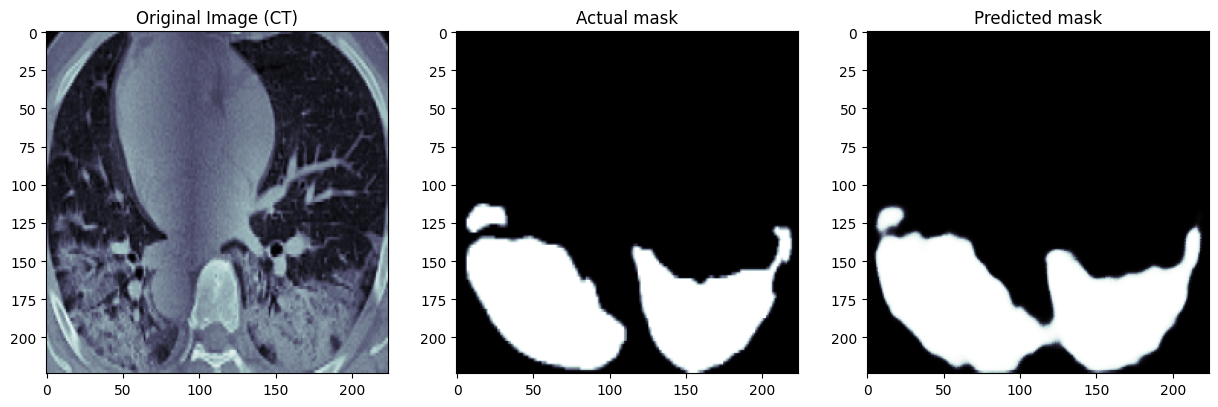

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


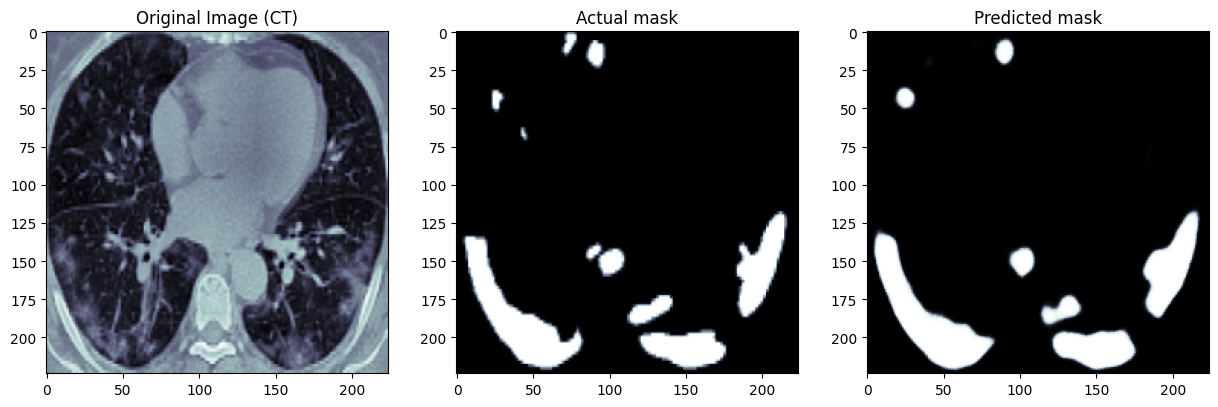

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


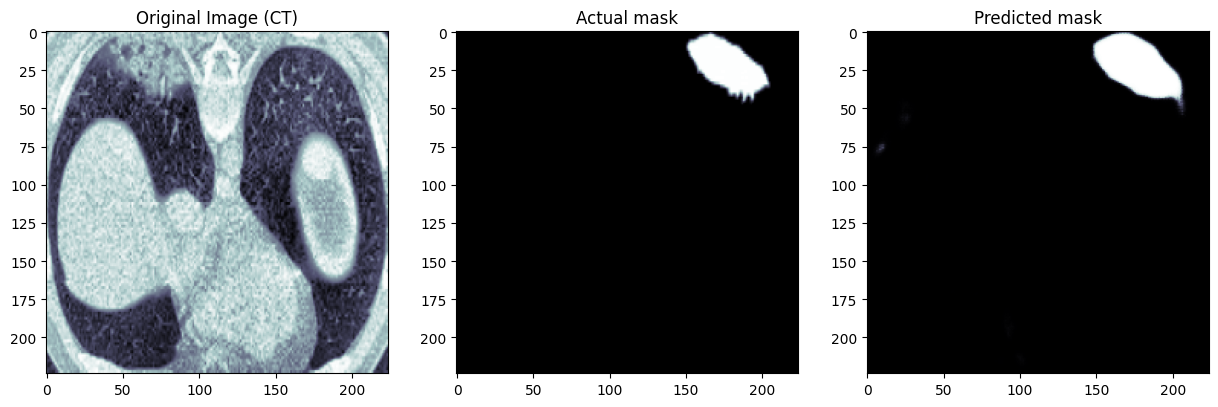

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


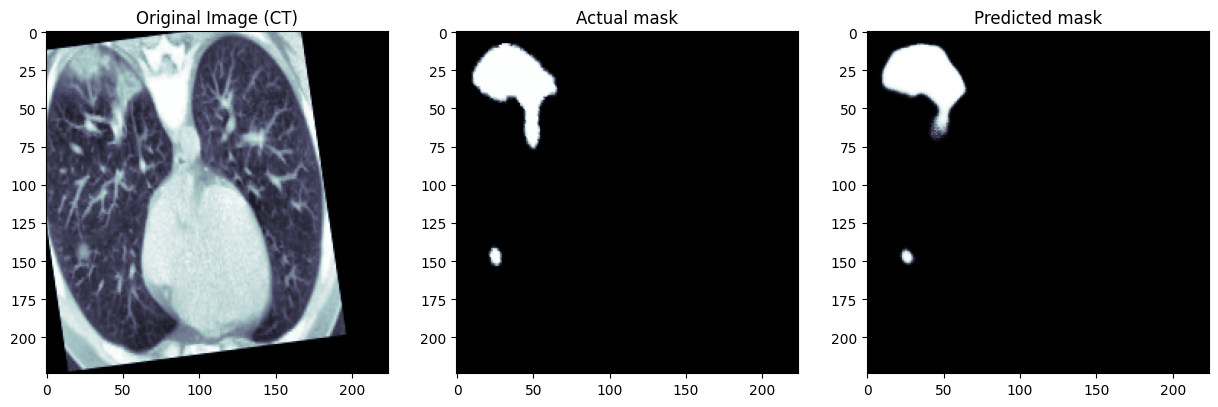

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


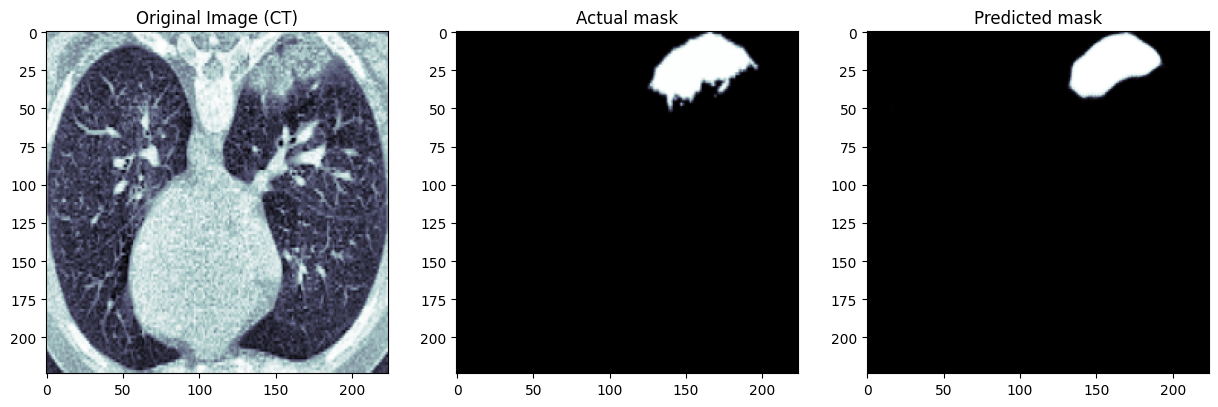

In [ ]:
for i in [2001,1717, 1890,1770,1655]:
    compare_actual_and_predicted(i)